* https://x.com/joker_peaches/status/1813786856326303936
* https://x.com/makaishi2/status/1814595311161254308

<img src="IMG_5031.jpg" width=40%>

α = 0.06
prior = Beta(1, 1) = Beta{Float64}(α=1.0, β=1.0)
posterior_p_X = posterior_dist(4, 5, prior) = Beta{Float64}(α=5.0, β=2.0)
posterior_p_Y = posterior_dist(60, 100, prior) = Beta{Float64}(α=61.0, β=41.0)
(cdf_Δp(0.0), 1 - cdf_Δp(0.0)) = (0.2376623137283716, 0.7623376862716285)
expectation_value(identity, pdf_Δp, -1.0, 1.0) = 0.1162464985994375
ci = highest_density_interval(quantile_Δp, α) = (-0.1998896700024479, 0.3998402879948816)
pval = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0) = 0.32931285779247715


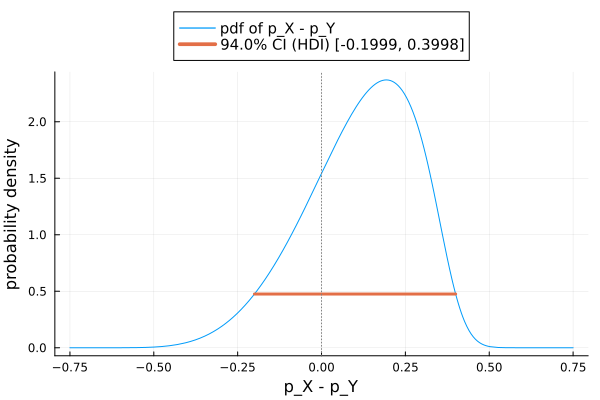

In [1]:
using Distributions
using Optim
using QuadGK
using Roots
using StatsPlots
default(fmt=:png, legendfontsize=10)

"X ~ beta1, Y ~ beta2 のときの X - Y の分布のpdfを作成"
function get_pdf_of_diff(beta1::Beta, beta2::Beta)
    pdf_diff(Δ) = -1 ≤ Δ ≤ 1 ? quadgk(max(0, -Δ), min(1, 1-Δ)) do q
        pdf(beta1, q+Δ) * pdf(beta2, q)
    end[1] : 0.0
    pdf_diff
end

"X ~ beta1, Y ~ beta2 のときの X - Y の分布のcdfを作成"
function get_cdf_of_diff(beta1::Beta, beta2::Beta)
    cdf_diff(Δ) = Δ < -1 ? 0.0 : Δ ≤ 1 ? quadgk(max(0, -Δ), 1) do q
        cdf(beta1, q+Δ) * pdf(beta2, q)
    end[1] : 1.0
    cdf_diff
end

"累積分布函数 cdffunc(x) の逆函数を作成"
function get_quantile(cdffunc, xmin, xmax)
    quantilefunc(p) = p == 0 ? xmin : p == 1 ? xmax : find_zero((xmin, xmax)) do x
        cdffunc(x) - p
    end 
    quantilefunc
end

function expectation_value(f, pdffunc, xmin, xmax)
    quadgk(x -> f(x)*pdffunc(x), xmin, xmax)[1]
end

function highest_density_interval(quantilefunc, α = 0.05; alg = Brent())
    f(p) = quantilefunc(p + (1 - α)) - quantilefunc(p)
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    quantilefunc.((p, p + (1 - α)))
end

function pvalue_hdi(pdffunc, cdffunc, xmin, xmax, x₀; alg=Brent())
    p₀ = pdffunc(x₀)
    xmode = optimize(δ -> -pdffunc(δ), xmin, xmax, alg).minimizer
    f(x) = pdffunc(x) - p₀
    if x₀ == xmode
        1.0
    elseif x₀ > xmode
        x₁ = find_zero(f, (xmin, xmode))
        cdffunc(x₁) + (1 - cdffunc(x₀))
    else
        x₁ = find_zero(f, (xmode, xmax))
        cdffunc(x₀) + (1 - cdffunc(x₁))
    end
end

function posterior_dist(k, n, prior::Beta=Beta(1, 1))
    a, b = params(prior)
    Beta(a+k, b+n-k)
end

α = 0.06
@show α

@show prior = Beta(1, 1)
@show posterior_p_X = posterior_dist(4, 5, prior)
@show posterior_p_Y = posterior_dist(60, 100, prior)

pdf_Δp = get_pdf_of_diff(posterior_p_X, posterior_p_Y)
cdf_Δp = get_cdf_of_diff(posterior_p_X, posterior_p_Y)
quantile_Δp = get_quantile(cdf_Δp, -1.0, 1.0)

@show cdf_Δp(0.0), 1-cdf_Δp(0.0)
@show expectation_value(identity, pdf_Δp, -1.0, 1.0)
@show ci = highest_density_interval(quantile_Δp, α)
#@show cdf_Δp(ci[2]) - cdf_Δp(ci[1])
@show pval = pvalue_hdi(pdf_Δp, cdf_Δp, -1.0, 1.0, 0.0)
#@show ci_pval = highest_density_interval(quantile_Δp, pval)

ci_rounded = collect(round.(ci; sigdigits=4))
plot(pdf_Δp, -0.75, 0.75; label="pdf of p_X - p_Y")
plot!(collect(ci), fill(pdf_Δp(ci[1]), 2); label="$(100(1-α))% CI (HDI) $(ci_rounded)", lw=3)
vline!([0.0]; label="", c=:gray, ls=:dot)
plot!(xguide="p_X - p_Y", yguide="probability density")
plot!(xtick=-1:0.25:1)
plot!(legend=:outertop)

mean(posterior_p_X) = 0.7142857142857143
mean(posterior_p_Y) = 0.5980392156862745


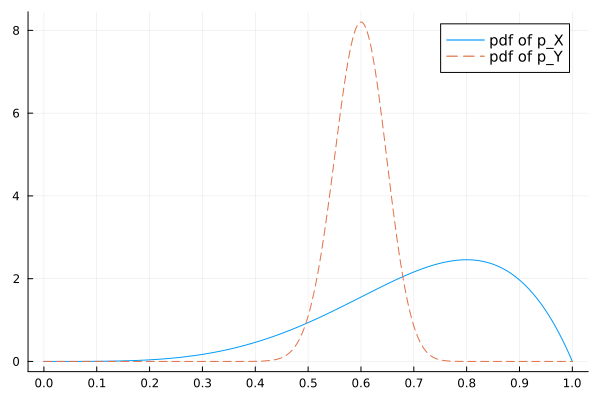

In [2]:
@show mean(posterior_p_X)
@show mean(posterior_p_Y)
plot(δ -> pdf(posterior_p_X, δ), 0, 1; label="pdf of p_X")
plot!(δ -> pdf(posterior_p_Y, δ), 0, 1; label="pdf of p_Y", ls=:dash)
plot!(xtick=0:0.1:1)

α = 0.06
prior = Beta(1, 1) = Beta{Float64}(α=1.0, β=1.0)
posterior_p_X = posterior_dist(4, 5, prior) = Beta{Float64}(α=5.0, β=2.0)
posterior_p_Y = posterior_dist(60, 100, prior) = Beta{Float64}(α=61.0, β=41.0)
(myecdf(Δ, 0), 1 - myecdf(Δ, 0)) = (0.237337, 0.762663)
mean(Δ) = 0.11641452795290437
ci = myhdi(Δ, α) = (-0.19819915477636357, 0.40082250209740056)
pval = mypvalue(Δ, 0) = 0.33


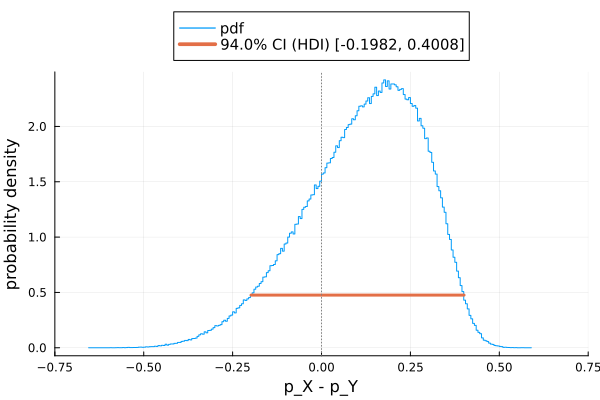

In [3]:
using Distributions
using StatsPlots
default(fmt=:png)

myecdf(A, x) = count(≤(x), A)/length(A)
myepdf(A, x; h=0.01) = (myecdf(A, x+h) - myecdf(A, x-h)) / (2h)

function _myhdi(A_sorted, α=0.05)
    n = length(A_sorted)
    m = floor(Int, (1 - α) * n)
    val, k = findmin(k -> A_sorted[k+m] - A_sorted[k], 1:n-m)
    A_sorted[k], A_sorted[k+m]
end

myhdi!(A, α=0.05) = _myhdi(sort!(A), α)
myhdi(A, α=0.05) = myhdi!(copy(A), α)

function _mypvalue(A_sorted, x=0.0; αs=0:0.0005:1) # very slow!
    k = findlast(αs) do α
        ci = _myhdi(A_sorted, α)
        ci[1] ≤ x ≤ ci[2]
    end
    round(αs[k], sigdigits=2)
end

mypvalue!(A, x) = _mypvalue(sort!(A), x)
mypvalue(A, x) = mypvalue!(copy(A), x)

function posterior_dist(k, n, prior::Beta=Beta(1, 1))
    a, b = params(prior)
    Beta(a+k, b+n-k)
end

α = 0.06
@show α

@show prior = Beta(1, 1)
@show posterior_p_X = posterior_dist(4, 5, prior)
@show posterior_p_Y = posterior_dist(60, 100, prior)

L = 10^6
p_X = rand(posterior_p_X, L)
p_Y = rand(posterior_p_Y, L)
Δ = p_X - p_Y

@show myecdf(Δ, 0), 1-myecdf(Δ, 0)
@show mean(Δ)
@show ci = myhdi(Δ, α)
#@show myecdf(Δ, ci[2]) - myecdf(Δ, ci[1])
@show pval = mypvalue(Δ, 0)
#@show ci_pval = myhdi(Δ, pval)

ci_rounded = collect(round.(ci; sigdigits=4))
stephist(Δ; norm=true, label="pdf", xlim=(-0.75, 0.75))
plot!(collect(ci), fill(myepdf(Δ, ci[1]), 2); label="$(100(1-α))% CI (HDI) $ci_rounded", lw=3)
vline!([0.0]; label="", c=:gray, ls=:dot)
plot!(xguide="p_X - p_Y", yguide="probability density")
plot!(xtick=-1:0.25:1)
plot!(legend=:outertop)